## Regression Comparison

Let's look at standard logistic regression, Ridge Regression, and Lasso Regression and see how they compare when examining breast cancer diagnosis.

In [3]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import math
import seaborn as sns
import sklearn
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample

%matplotlib inline
sns.set_style('white')

In [2]:
full_df = pd.read_csv('Breast Cancer Diagnosis/breast-cancer-wisconsin.data', 
                      names=['id','clumpthickness','cellsize','cellshape','adhesion','epithelialsize',
                             'barenuclei','chromatin','nucleoli','mitosis','class']
                     ) 
full_df['class'] = full_df['class'].replace({2:0, 4:1})
full_df['barenuclei'] = pd.to_numeric(full_df['barenuclei'], errors='coerce')
full_df = full_df.dropna()
full_df.shape

(683, 11)

Let's resample the positives to deal with class imbalance.

In [4]:
neg_df = full_df[full_df['class']==0]
pos_df = full_df[full_df['class']==1]
print(len(neg_df), len(pos_df))

pos_df_upsampled = resample(pos_df, n_samples=444)
print(pos_df_upsampled.shape)

full_df = pd.concat([pos_df_upsampled, neg_df])

444 239
(444, 11)


In [5]:
full_df.head()

,id,clumpthickness,cellsize,cellshape,adhesion,epithelialsize,barenuclei,chromatin,nucleoli,mitosis,class
282,488173,1,4,3,10,4,10.0,5,6,1,1
103,1168359,8,2,3,1,6,3.0,7,1,1,1
261,263538,5,10,10,6,10,10.0,10,6,5,1
457,1259008,8,8,9,6,6,3.0,10,10,1,1
226,1227481,10,5,7,4,4,10.0,8,9,1,1


In [6]:
Y = full_df['class'].values.reshape(-1, 1).ravel()
X = full_df.loc[:, 'clumpthickness':'mitosis']

In [7]:
X.shape

(888, 9)

Let's create some new features to broaden the analysis.

In [8]:
X['cell_epithelial'] = X['cellsize'] * X['epithelialsize']
X['bare_nucleoli'] = X['barenuclei'] * X['nucleoli']
X['clump_shape'] = X['clumpthickness'] * X['cellshape']
X['chromatin_adhesion'] = X['chromatin'] * X['adhesion']
X['mitosis_shape'] = X['mitosis'] * X['cellshape']
X['clump_bare'] = X['clumpthickness'] * X['barenuclei']
X['size_2'] = X['cellsize'] * X['cellsize']
X['nucleoli_2'] = X['nucleoli'] * X['nucleoli']

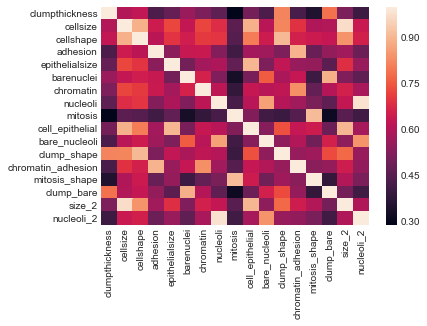

In [16]:
corrmat = X.corr()
sns.heatmap(corrmat)

In [10]:
# To negate the automatic regularization in the LogisticRegression() model, we can set C to be large.

regr = linear_model.LogisticRegression(penalty='l2', C=1e9, fit_intercept=False)
ridg = linear_model.LogisticRegression(penalty='l2', C=0.05, fit_intercept=False)
lass = linear_model.LogisticRegression(penalty='l1', C=0.05, fit_intercept=False)

regr.fit(X,Y)
ridg.fit(X,Y)
lass.fit(X,Y)

print(regr.score(X,Y))
print(ridg.score(X,Y))
print(lass.score(X,Y))

0.970720720721
0.96509009009
0.970720720721


In [11]:
n_folds = 6
# With 6 folds, the training set will have about 750 data points, and the test set will have about 150.
# Changing this parameter changed the variance in the accuracy, but not by much.

regr_score = cross_val_score(regr, X, Y, cv=n_folds)
ridg_score = cross_val_score(ridg, X, Y, cv=n_folds)
lass_score = cross_val_score(lass, X, Y, cv=n_folds)

print('Vanilla Regression: %.2f +/- %.2f' % (regr_score.mean(), 2*regr_score.std()))
print('Ridge Regression: %.2f +/- %.2f' % (ridg_score.mean(), 2*ridg_score.std()))
print('Lasso Regression: %.2f +/- %.2f' % (lass_score.mean(), 2*lass_score.std()))

Vanilla Regression: 0.97 +/- 0.02
Ridge Regression: 0.96 +/- 0.03
Lasso Regression: 0.96 +/- 0.03


Accuracy for these models on this data set are are about equal. Let's see if anything interesting happened with the coefficients.

In [12]:
regr.coef_

array([[ 0.30065154,  0.07821219, -2.69773601,  0.4990903 , -1.03566606,
         0.51635194,  0.4717478 , -0.89065945, -5.76585694,  0.23464884,
        -0.06950369,  0.02702092,  0.02399313,  2.9917443 ,  0.03147798,
        -0.11167854,  0.15034265]])

In [13]:
ridg.coef_

array([[-0.45526822, -0.27814842, -0.45572328, -0.30928379, -0.72799466,
        -0.07824774, -0.25826088, -0.43431281, -0.34963554,  0.20381757,
        -0.07334886,  0.12551156,  0.24980427,  0.37801734,  0.17011643,
        -0.08820459,  0.09596346]])

In [14]:
lass.coef_

array([[-0.52747011, -0.01227926, -0.3170529 ,  0.        , -1.12578442,
         0.        , -0.00135007, -0.03732087,  0.        ,  0.25345672,
        -0.03007674,  0.14177325,  0.09366335,  0.11918975,  0.11378914,
        -0.10466345,  0.03716208]])

Nothing too crazy -- these values are all reasonable. Lasso did eliminate some of the features, which is nice. I suspect this data set is too small to really see substantial differences between the models. I played with C values (1/lambda), and I can increase the L1 regularization to the point where only 5-6 features remain and still get 94-95% accuracy. For a larger dataset, this could be a powerful tool. The L2 regularization doesn't prove to be so necessary for this particular model -- none of the coefficients in the Vanilla Regression are getting out of control, and Vanilla still performs slightly better on the cross validation set. 

These accuracy values are also very similar to that I was able to achieve with a simple Random Forest model. 

## Various Feature Selection Options

Let's try: selectKbest, RFE, PCA.

In [18]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA

In [20]:
skb = SelectKBest(k=5)
rfe = RFE(regr, 5)
pca = PCA(n_components=5)

In [34]:
rfe.fit(X,Y)
print(rfe.ranking_)
X_rfe = rfe.transform(X)

[ 1 11  1  2  6  1  3  4  1  7  9 12 13  1 10  8  5]


In [35]:
n_folds = 6
# With 6 folds, the training set will have about 750 data points, and the test set will have about 150.
# Changing this parameter changed the variance in the accuracy, but not by much.

regr_score = cross_val_score(regr, X_rfe, Y, cv=n_folds)
ridg_score = cross_val_score(ridg, X_rfe, Y, cv=n_folds)
lass_score = cross_val_score(lass, X_rfe, Y, cv=n_folds)

print('RFE Vanilla Regression: %.2f +/- %.2f' % (regr_score.mean(), 2*regr_score.std()))
print('RFE Ridge Regression: %.2f +/- %.2f' % (ridg_score.mean(), 2*ridg_score.std()))
print('RFE Lasso Regression: %.2f +/- %.2f' % (lass_score.mean(), 2*lass_score.std()))

RFE Vanilla Regression: 0.96 +/- 0.03
RFE Ridge Regression: 0.94 +/- 0.04
RFE Lasso Regression: 0.95 +/- 0.04


In [30]:
skb.fit(X,Y)
X_skb = skb.transform(X)

In [36]:
n_folds = 6
# With 6 folds, the training set will have about 750 data points, and the test set will have about 150.
# Changing this parameter changed the variance in the accuracy, but not by much.

regr_score = cross_val_score(regr, X_skb, Y, cv=n_folds)
ridg_score = cross_val_score(ridg, X_skb, Y, cv=n_folds)
lass_score = cross_val_score(lass, X_skb, Y, cv=n_folds)

print('RFE Vanilla Regression: %.2f +/- %.2f' % (regr_score.mean(), 2*regr_score.std()))
print('RFE Ridge Regression: %.2f +/- %.2f' % (ridg_score.mean(), 2*ridg_score.std()))
print('RFE Lasso Regression: %.2f +/- %.2f' % (lass_score.mean(), 2*lass_score.std()))

RFE Vanilla Regression: 0.76 +/- 0.13
RFE Ridge Regression: 0.76 +/- 0.13
RFE Lasso Regression: 0.78 +/- 0.15


That did poorly for the same number of features!

In [37]:
pca.fit(X)
X_pca = pca.transform(X)

In [38]:
n_folds = 6
# With 6 folds, the training set will have about 750 data points, and the test set will have about 150.
# Changing this parameter changed the variance in the accuracy, but not by much.

regr_score = cross_val_score(regr, X_pca, Y, cv=n_folds)
ridg_score = cross_val_score(ridg, X_pca, Y, cv=n_folds)
lass_score = cross_val_score(lass, X_pca, Y, cv=n_folds)

print('RFE Vanilla Regression: %.2f +/- %.2f' % (regr_score.mean(), 2*regr_score.std()))
print('RFE Ridge Regression: %.2f +/- %.2f' % (ridg_score.mean(), 2*ridg_score.std()))
print('RFE Lasso Regression: %.2f +/- %.2f' % (lass_score.mean(), 2*lass_score.std()))

RFE Vanilla Regression: 0.92 +/- 0.04
RFE Ridge Regression: 0.92 +/- 0.04
RFE Lasso Regression: 0.92 +/- 0.04


I'm surprised this isn't as good as RFE -- it seems like it should have captured more information from the dataset. I suppose it isn't sensitive to which values are correlated to the output Y, though, while RFE is specifically trained to choose those. 